### 一.原理
GraphSAGE是对GCN的优化，其中SAGE是sample和aggreage的缩写，从名称我们也可以看出它主要优化的两个方向：即采样和聚合   

#### 1.1 采样     

GCN的训练需要图的全局信息（连接矩阵$\tilde{L}_{sym}$），对于太大的图，可能没有足够的内存或者显存进行训练，借鉴DNN中常用的批量训练方式，GCN也可以利用采样来进行训练，它的采样主要关注两方面：1）**采样训练节点**：由于GCN每增加一层，节点所利用到的邻居信息就要往外扩展一层，所以对于$k$层的GCN网络，我们需要每个训练节点的$k$阶子图样本；2）**采样邻居节点**：另外，由于某些超级节点（度特别大的节点，比如平均度为10的图，某些节点的度可能会有100W）存在，也有造成OOM的风险，对于$k$阶子图的规模也要进行控制，这可以通过限制每层邻居节点数量来控制，如下图第一层采样了3个节点，第二层采样了2个节点（有放回采样）
![avatar](./pic/sage1.jpg)   

#### 1.2 聚合

这一部分其实都是借鉴的DNN中的常见操作，比如取平均/求和/池化等等，这里可以自己设计，需要满足两点：1）不对不同的邻居数量，需要有相同维度的输出，比如$|Agg(v_1,v_2,v_3)|=|Agg(v_1,v_2)|$（$|\cdot|$表示维度）；2）平移不变性，对于不同的输入顺序需要有相同的输出，比如$|Agg(v_1,v_2)=Agg(v_2,v_1)|$，接下来再利用上面的例子演示一下聚合过程：  
>（1）首先将训练节点周围的3个邻居信息聚合，得到图1；  
>（2）然后再将3个邻居的邻居信息聚合到邻居，得到图2，这时第一层GCN就结束了；  
>（3）最后，再次将3个邻居信息聚合到训练节点，得到图3，第二层GCN结束。   

其中，淡蓝色的点，表示该次操作后不再被需要的点，粉红的点表示采样点，红色和橘黄色分别表示第一轮GCN和第二轮GCN聚合后的点，红色有向边表示第一层的GCN聚合，橘黄色有向边表示第二层的GCN聚合，无向边表示不操作
![avatar](./pic/sage2.jpg)

### 二.实现

In [1]:
#1.准备数据
from code.graph_sage import *
data = CoraData().data
x = data.x / data.x.sum(1, keepdims=True)  # 归一化数据，使得每一行和为1
train_index = np.where(data.train_mask)[0]
train_label = data.y
test_index = np.where(data.test_mask)[0]

Using Cached file: E:\datas\Algs\GNN\cora\ch7_cached.pkl


In [2]:
#2.训练模型
INPUT_DIM = 1433  # 输入维度
# Note: 采样的邻居阶数需要与GCN的层数保持一致
HIDDEN_DIM = [64, 7]  # 隐藏单元节点数
NUM_NEIGHBORS_LIST = [10, 10]  # 每阶采样邻居的节点数
BTACH_SIZE = 16  # 批处理大小
EPOCHS = 100
NUM_BATCH_PER_EPOCH = 20  # 每个epoch循环的批次数
LEARNING_RATE = 0.01  # 学习率
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
model = GraphSage(input_dim=INPUT_DIM, hidden_dim=HIDDEN_DIM,
                      num_neighbors_list=NUM_NEIGHBORS_LIST).to(DEVICE)
print(model)
criterion = nn.CrossEntropyLoss().to(DEVICE)
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=5e-4)

GraphSage(
  in_features=1433, num_neighbors_list=[10, 10]
  (gcn): ModuleList(
    (0): SageGCN(
      in_features=1433, out_features=64, aggr_hidden_method=sum
      (aggregator): NeighborAggregator(in_features=1433, out_features=64, aggr_method=mean)
    )
    (1): SageGCN(
      in_features=64, out_features=7, aggr_hidden_method=sum
      (aggregator): NeighborAggregator(in_features=64, out_features=7, aggr_method=mean)
    )
  )
)


In [3]:
for e in range(EPOCHS):
    model.train()
    for batch in range(NUM_BATCH_PER_EPOCH):
        batch_src_index = np.random.choice(train_index, size=(BTACH_SIZE,))
        batch_src_label = torch.from_numpy(train_label[batch_src_index]).long().to(DEVICE)
        batch_sampling_result = multihop_sampling(batch_src_index, NUM_NEIGHBORS_LIST, data.adjacency_dict)
        batch_sampling_x = [torch.from_numpy(x[idx]).float().to(DEVICE) for idx in batch_sampling_result]
        batch_train_logits = model(batch_sampling_x)
        loss = criterion(batch_train_logits, batch_src_label)
        optimizer.zero_grad()
        loss.backward()  # 反向传播计算参数的梯度
        optimizer.step()  # 使用优化方法进行梯度更新
#         print("Epoch {:03d} Batch {:03d} Loss: {:.4f}".format(e, batch, loss.item()))
    # test
    model.eval()
    with torch.no_grad():
        test_sampling_result = multihop_sampling(test_index, NUM_NEIGHBORS_LIST, data.adjacency_dict)
        test_x = [torch.from_numpy(x[idx]).float().to(DEVICE) for idx in test_sampling_result]
        test_logits = model(test_x)
        test_label = torch.from_numpy(data.y[test_index]).long().to(DEVICE)
        predict_y = test_logits.max(1)[1]
        accuarcy = torch.eq(predict_y, test_label).float().mean().item()
#         print("Test Accuracy: ", accuarcy)

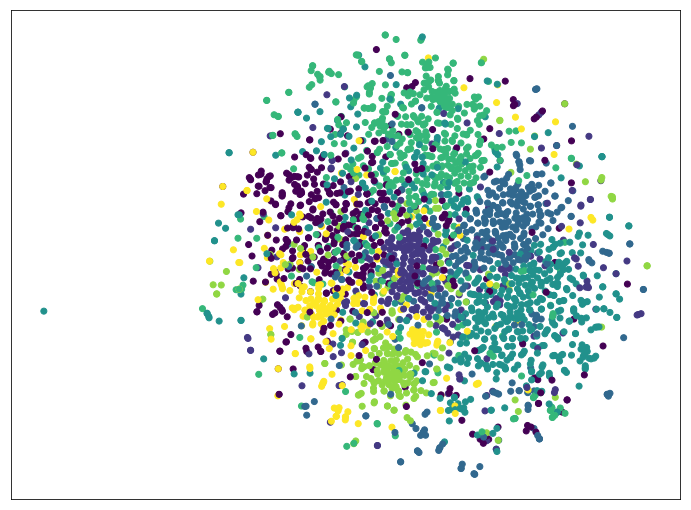

In [5]:
#3.查看效果
import warnings
warnings.filterwarnings("ignore")
%matplotlib inline
from sklearn import manifold
tsne = manifold.TSNE(n_components=2,init="pca")
X_tsne = tsne.fit_transform(x)
total_sampling_result = multihop_sampling(list(range(len(x))), NUM_NEIGHBORS_LIST, data.adjacency_dict)
total_x = [torch.from_numpy(x[idx]).float().to(DEVICE) for idx in total_sampling_result]
pred = model(total_x).max(1)[1].numpy()
x_min, x_max = X_tsne.min(0), X_tsne.max(0)
X_norm = (X_tsne - x_min) / (x_max - x_min)  # 归一化
plt.figure(figsize=(12, 9))
plt.scatter(X_norm[:,0],X_norm[:,1],c=pred)
plt.yticks([])
plt.xticks([])
plt.show()